In [10]:
# todo 
# evaluation metric match, data loading also matches - without transliteration. transliteration changes things a little bit.
# make an all in one notebook..


In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
import matplotlib.colors as mcolors
from matplotlib.ticker import FuncFormatter
import json
from IPython.display import display, HTML
import difflib
from termcolor import colored
import unicodedata
import pandas as pd
from aksharamukha import transliterate
%matplotlib inline

In [4]:
# Define the file path
experiment_number = "big_7pgtrained_1x" 
threshold = 0.20 # heuristic threshold
gcer=True

###
fold_1_path = f'/home/ocr_proj/OCR/post_correction/pe-ocr-sanskrit/outputs/experiment_{experiment_number}/test_fold_1/'

## Helper Fuctions

### Visualizations Functions

In [5]:
def highlight_changes(line1, line2):
    # Generate a diff between the two lines
    diff = list(difflib.ndiff(line1, line2))

    # Create colored output based on diff
    highlighted_line1 = []
    highlighted_line2 = []

    i = 0
    while i < len(diff):
        if diff[i].startswith('- ') and i+1 < len(diff) and diff[i+1].startswith('+ '):
            # Replace operation
            highlighted_line1.append(colored(diff[i][2:], 'yellow'))
            highlighted_line2.append(colored(diff[i+1][2:], 'yellow'))
            i += 2
        elif diff[i].startswith('- '):
            # Delete operation
            highlighted_line1.append(colored(diff[i][2:], 'blue'))
            highlighted_line2.append(colored(' ', 'blue'))
            i += 1
        elif diff[i].startswith('+ '):
            # Insert operation
            highlighted_line1.append(colored(' ', 'red'))
            highlighted_line2.append(colored(diff[i][2:], 'red'))
            i += 1
        elif diff[i].startswith('  '):
            # Unchanged characters
            highlighted_line1.append(diff[i][2:])
            highlighted_line2.append(diff[i][2:])
            i += 1
        else:
            # Skip '?' lines
            i += 1

    final_line1 = ''.join(highlighted_line1)
    final_line2 = ''.join(highlighted_line2)

    # Ensure equal length by padding with spaces
    max_length = max(len(final_line1), len(final_line2))
    final_line1 = final_line1.ljust(max_length)
    final_line2 = final_line2.ljust(max_length)


    print("Ground Truth  : " + final_line2)
    print("Prediction    : " + final_line1)


# Example usage:
highlight_changes("abcdef", "abxcef")

def analyse_line(df,id):

    first_image_path = df['path'].iloc[id]    
    # Load and display the image using matplotlib
    img = mpimg.imread(first_image_path)

    # Print legend
    print(colored("Blue     ", "blue") + ": Extra")
    print(colored("Red   ", "red") + ": Missing")
    print(colored("Yellow  ", "yellow") + ": Replaced")
    print("No color: Unchanged")
    print('\n')


    plt.figure(figsize=(30, 30))
    plt.axis('off')
    plt.imshow(img, cmap='gray')

    print(f'7 Page trained OCR Output GCER:{str(df['pre_gcer'].iloc[id]*100)} CER:{str(df['pre_cer'].iloc[id]*100)}')
    highlight_changes(df['input_text'].iloc[id], df['target_text'].iloc[id])
    print('')
    print(f'40 Page trained OCR Output GCER:{str(df['pure_cnnlstm_gcer'].iloc[id]*100)} CER:{str(df['pure_cnnlstm_cer'].iloc[id]*100)}')
    highlight_changes(df['pure_cnnlstm_text'].iloc[id], df['target_text'].iloc[id])
    print('')
    print(f'Hybrid OCR Output GCER:{str(df['post_gcer'].iloc[id]*100)} CER:{str(df['post_cer'].iloc[id]*100)}')#
    highlight_changes(df['predicted_text'].iloc[id], df['target_text'].iloc[id])
    

    print('\nOriginal Line Image:')


def format_json(data):
    # Recursive function to format JSON data
    def format_item(item):
        if isinstance(item, dict):
            formatted = "<ul>"
            for key, value in item.items():
                formatted += f"<li><strong>{key}:</strong> {format_item(value)}</li>"
                formatted += f"<br>"
            formatted += "</ul>"
            return formatted
        elif isinstance(item, list):
            formatted = "<ul>"
            for sub_item in item:
                formatted += f"<li>{format_item(sub_item)}</li>"
                formatted += f"<br>"
            formatted += "</ul>"
            return formatted
        else:
            return f"<span>{item}</span>"
    
    return format_item(data)

def display_side_by_side(json_data1, json_data2, title1="JSON File 1", title2="JSON File 2"):
    formatted_json1 = format_json(json_data1)
    formatted_json2 = format_json(json_data2)
    
    # Create HTML for side-by-side display
    html = f"""
    <div style="display: flex; justify-content: space-between;">
        <div style="width: 45%; padding: 10px; border: 1px solid #ddd; box-shadow: 2px 2px 5px rgba(0, 0, 0, 0.1);">
            <h3>{title1}</h3>
            {formatted_json1}
        </div>
        <div style="width: 45%; padding: 10px; border: 1px solid #ddd; box-shadow: 2px 2px 5px rgba(0, 0, 0, 0.1);">
            <h3>{title2}</h3>
            {formatted_json2}
        </div>
    </div>
    """
    
    display(HTML(html))





Ground Truth  : abxc ef
Prediction    : ab cdef


### Evaluation Functions

In [5]:
### EVALUATION FUNCTIONS BELOW


def list_correct_grapheme_clusters(devanagari_string):
    combining_marks = {'्', 'ँ', 'ं', 'ः', 'ा', 'ि', 'ी', 'ु', 'ू', 'ृ', 'ॄ', 'ॢ', 'ॣ', 'े', 'ै', 'ो', 'ौ', '़','ॅ'}
    graphemes = []
    temp_grapheme = ""
    for char in devanagari_string:
        if unicodedata.combining(char) == 0 and char not in combining_marks:
            # If temp_grapheme has something and last char was not virama, append to graphemes
            if temp_grapheme and not temp_grapheme.endswith('्'):
                graphemes.append(temp_grapheme)
                temp_grapheme = char
            else:
                temp_grapheme += char
        else:
            temp_grapheme += char  # Add combining mark or virama to current grapheme

    # Append the last grapheme if exists
    if temp_grapheme:
        graphemes.append(temp_grapheme)

    return graphemes


def non_matching_graphemes(s, s1):

    # Split both strings into graphemes
    graphemes_s = list_correct_grapheme_clusters(s)
    graphemes_s1 = list_correct_grapheme_clusters(s1)

    # Find the LCS to align graphemes instead of characters
    m, n = len(graphemes_s), len(graphemes_s1)
    dp = [[0] * (n + 1) for _ in range(m + 1)]
    for i in range(1, m + 1):
        for j in range(1, n + 1):
            if graphemes_s[i - 1] == graphemes_s1[j - 1]:
                dp[i][j] = dp[i - 1][j - 1] + 1
            else:
                dp[i][j] = max(dp[i - 1][j], dp[i][j - 1])

    # Reconstruct the sequence of non-matching graphemes
    non_matching = []
    error_count = 0
    while m > 0 and n > 0:
      # if the grapheme clusters match
        if graphemes_s[m - 1] == graphemes_s1[n - 1]:
            m, n = m - 1, n - 1

      # if they dont match
        else:
            temp_s, temp_s1 = "", ""

            while m > 0 and (n == 0 or dp[m][n] == dp[m-1][n]):
                temp_s = graphemes_s[m - 1] + temp_s
                m -= 1

            while n > 0 and (m == 0 or dp[m][n] == dp[m][n-1]):
                temp_s1 = graphemes_s1[n - 1] + temp_s1
                n -= 1

            # if(len(temp_s)>3):
              # print(list_correct_grapheme_clusters(temp_s))
            if(len(list_correct_grapheme_clusters(temp_s))>=len(list_correct_grapheme_clusters(temp_s1))):

              temp_list = list_correct_grapheme_clusters(temp_s)

            else:
              temp_list = list_correct_grapheme_clusters(temp_s1)

            temp_list.reverse()
            error_count += len(temp_list)
            non_matching.extend(temp_list)

    # print(m,n)
    non_matching.reverse()
    # print(non_matching)
    # print(graphemes_s)
    return(error_count/len(graphemes_s))

def longest_common_subsequence(s, s1):
    # Create the DP table
    m, n = len(s), len(s1)
    dp = [[0] * (n + 1) for _ in range(m + 1)]

    # Fill the DP table
    for i in range(1, m + 1):
        for j in range(1, n + 1):
            if s[i - 1] == s1[j - 1]:
                dp[i][j] = dp[i - 1][j - 1] + 1
            else:
                dp[i][j] = max(dp[i - 1][j], dp[i][j - 1])

    # Reconstruct the LCS
    lcs = []
    while m > 0 and n > 0:
        if s[m - 1] == s1[n - 1]:
            lcs.append(s[m - 1])
            m -= 1
            n -= 1
        elif dp[m - 1][n] > dp[m][n - 1]:
            m -= 1
        else:
            n -= 1

    # The LCS is built backwards, so reverse it
    return ''.join(reversed(lcs))

def get_unicode_eval(pg_annot,pg_pred):
    s = pg_pred
    s1 = pg_annot

    lcs = longest_common_subsequence(s, s1)
    #   print(lcs)
    # print(modelname+" LCS: "+f'{len(lcs)/len(s)}')
    denom = len(s1) if len(s1)>= len(s) else len(s)
    return(1-(len(lcs)/denom))

def calculate_gcer(pg_annot,pg_pred,transliteration=False):
    if transliteration:
        pg_annot = transliterate.process( 'IAST', 'Devanagari', pg_annot)
        pg_pred = transliterate.process( 'IAST', 'Devanagari', pg_pred)

    errors = non_matching_graphemes(pg_annot, pg_pred)
    return errors

def calculate_cer(pg_annot,pg_pred,transliteration=False):
    if transliteration:
        pg_annot = transliterate.process( 'IAST', 'Devanagari', pg_annot)
        pg_pred = transliterate.process( 'IAST', 'Devanagari', pg_pred)

    errors = get_unicode_eval(pg_annot, pg_pred)
    return errors

def calculate_error(transcript,predicted_text,gcer=False,transliteration=True):
    if gcer:
        error = calculate_gcer(transcript,predicted_text,transliteration=transliteration)
    else:
        error = calculate_cer(transcript,predicted_text,transliteration=transliteration)
    return error


## Dataframe Preparation

In [6]:
csv_file_path_1 = fold_1_path +'analysis.csv'
df_1 = pd.read_csv(csv_file_path_1, delimiter=';', encoding='utf-8')
df = pd.concat([df_1], axis=0, ignore_index=True)

In [9]:
df.head()

,difference,pre_cer,post_cer,input_text,target_text,predicted_text,path
0,-0.04,0.07,0.03,masaṃbaṃdhasyaprāthamikabodheevaviṣayatvāpatte...,masaṃbaṃdhasyaprāthamikabodheevaviṣayatvāpatte...,masaṃbaṃdhasyaprāthamikabodheevaviṣayatvāpatte...,/home/ocr_proj/OCR/vPostNAAC/line_images/test_...
1,-0.09,0.10,0.01,nyathānupapatyābhāvanāpibhiṣataïtisidadh_āṃtas...,nyathānupapatyābhāvanāpibhidyataïtisiddhāṃtaḥs...,nyathānupapatyābhāvanāpibhidyataïtisiddhāṃtaso...,/home/ocr_proj/OCR/vPostNAAC/line_images/test_...
2,-0.11,0.20,0.09,panvayanadhātvarathaḍananveyāt.saṃkhyāyāayyupa...,panvayenadhātvarthe'nanvayāt.saṃkhyāyāapyupadā...,panvayenadhātvarthamananveyāt.saṃkhyāyāapyupad...,/home/ocr_proj/OCR/vPostNAAC/line_images/test_...
3,-0.04,0.11,0.07,stadanyathānupapatyācayāgabhaṃdaïtivaiparītyam...,stadanyathānupapatyācayāgabhedaïtivaiparītyamā...,stadanyathānupapatyācayāgabhedaïtivaiparītyamā...,/home/ocr_proj/OCR/vPostNAAC/line_images/test_...
4,-0.01,0.08,0.07,somenopapadārthena.tasmāhavalekapotanyāyenasar...,somenopapadārthena.tasmātkhalekapotanyāyenasar...,somenopapadārthena.tasmāddavalekapotanyāyenasa...,/home/ocr_proj/OCR/vPostNAAC/line_images/test_...


In [7]:
# OK, the evaluation metric matches perfectly with Shagun's evaluation metric.

#OCR TEXT
_ocred_text_path = f'/home/ocr_proj/OCR/vPostNAAC/line_pred/test_big_big_07.txt'  #example: val_clean_clean_12
with open(_ocred_text_path, 'rt') as myfile:
    _ocred_text = myfile.read().replace('\n','')  #CHANGED

# GROUND TRUTH
_path_annot = '/home/ocr_proj/OCR/vPostNAAC/line_images'
_pg_annot = f'test_big/labels.txt'  # example: val_clean or test_clean
_annot_text = pd.read_table(f'{_path_annot}/{_pg_annot}', encoding="utf-8",header=None)
_annot_text.columns = ['image_path','labels']
_annot_text = _annot_text.labels.str.cat(sep='').replace(' ','') #CHANGED

# LOADING THE PURE CNN-LSTM PREDICTIONS
_ocred_text_path = f'/home/ocr_proj/OCR/vPostNAAC/line_pred/test_big_big_51.txt'  #example: val_clean_clean_12
with open(_ocred_text_path, 'rt') as myfile:
    _pure_cnnlstm_ocred_text = myfile.read().replace('\n','')

print('trained on 7 pages')
print(calculate_error(_annot_text,_ocred_text,gcer=True,transliteration=False))
print(calculate_error(_annot_text,_ocred_text,gcer=False,transliteration=False))
print('')
print('trained on 40 pages')
print(calculate_error(_annot_text,_pure_cnnlstm_ocred_text,gcer=True,transliteration=False))
print(calculate_error(_annot_text,_pure_cnnlstm_ocred_text,gcer=False,transliteration=False))

trained on 7 pages
0.22548076923076923
0.11082594493700415

trained on 40 pages
0.11057692307692307
0.04946336910872606


In [10]:
#the difference between the above GCER and CER and the below is transliteration. when we don't transliterate, the values match exactly.
# this means that the data loading, and the evaluation metric are the same. The difference is in transliteration.

transliteration = False
if transliteration:
    # Join all rows of target, input, and predicted text
    all_target_text = ''.join(transliterate.process('IAST', 'Devanagari',  row) for row in df['target_text'])
    all_ocred_text = ''.join(transliterate.process('IAST', 'Devanagari', row) for row in df['input_text']) #CHANGE
else:
    # Join all rows of target, input, and predicted text
    all_target_text = ''.join(row for row in df['target_text'])
    all_ocred_text = ''.join(row for row in df['input_text']) #CHANGE
#all_predicted_text = ''.join(transliterate.process('IAST', 'Devanagari', row.replace('\n','')) for row in df['predicted_text'])

all_target_text = transliterate.process('IAST', 'Devanagari', df.target_text.str.cat(sep=''))
all_ocred_text = transliterate.process('IAST', 'Devanagari', df.input_text.str.cat(sep=''))


print(calculate_error(all_target_text,all_ocred_text,gcer=True,transliteration=False)) #Transliteration false because we are already transliterating
print(calculate_error(all_target_text,all_ocred_text,gcer=False,transliteration=False))

0.2227556409025444
0.1140125903474003


In [12]:
print(len(_annot_text)) # loaded directly from devanagari
print(len(all_target_text)) #devanagari to IAST, and then back to devanagari
highlight_changes(_annot_text,all_target_text)

4286
4273
Ground Truth  : मसंबंधस्यप्राथमिकबोधेएवविषयत्वापत्तेश्चकिंचसप्तदशसंख्यायायागेन्वयेनतद्बहुत्वेसिद्धेतदन्यथानुपपत्याभावनापिभिद्यतइतिसिद्धांतःसोपिविलुप्येत।भवन्मतेसंख्यायाअपिभावनायामेवापन्वयेनधात्वर्थेऽनन्वयात्।संख्यायाअप्युपदार्थत्वाविशेषात्तेनसाक्षात्संख्यान्वयादेवभावनाभेदस्तदन्यथानुपपत्याचयागभेदइतिवैपरीत्यमापद्येत।अतःसप्तदशतायायागेन्वयेकिमपराद्धंसोमेनोपपदार्थेन।तस्मात्खलेकपोतन्यायेनसर्वेषांभावनान्वयइतिपक्षोनसिद्धांतसंमतइतिसोमविशिष्टयागकरणिकाफलभाव्यकाभावनेत्येवशाब्दबोधःसिद्धांतसंमतः॥  सचमत्वर्थळक्षणामंतरानोपपद्यतइति॥॥    ।इतिपंचमीकक्ष्या॥॥    ।कारकाणांक्रियान्वयइतिपक्षस्यपारिप्लवाधिकरणेन्यत्रचतत्रतत्रबहुशोभाष्यवार्तिकादौप्रतिपादनात्तदनभ्युपगमस्तुतंत्रमर्यादोल्लंघनमेव।तथाहिसप्तमेशास्त्रदीपिकायां,भावनान्वयतःपार्ष्ठिकोन्वयइतितंत्ररत्नेप्येकादशेसोमसमानन्यायेअवघातमंत्रविषयउक्तं॥  यदिधात्वर्थस्वरूपांगंमंत्रःस्यात्तदाप्रतिप्रहारंतद्भेदान्मंत्रोनधात्वर्थस्यैवकरणत्वेनफलस्यैवभाव्यत्वोरीकारात्॥यागभाव्यकभावनाहिसोमयागयोर्द्वारीभतवितुमर्हा।नहिप्रत्ययवाच्यातादृशी।स्वर्गकामाधिकरणविरोधात्॥  तत

In [13]:
print(len(_ocred_text)) # loaded directly from devanagari
print(len(all_ocred_text)) #devanagari to IAST, Post correction, and then back to devanagari
highlight_changes(_ocred_text,all_ocred_text)

# transliteration to IAST, and then back to devanagari changes ।। to ॥, । to .,ख्त्ीलि to ख्त्ईलि

4103
4089
Ground Truth  : मसंबंधस्यप्राथमिकबोधेएवविषयत्वापत्तेश्व्रकिचसप्तदशसख्यायायागेन्वयेनतद्वहत्वेसिधेतदन्यथानुपपत्याभावनापिभिषतइतिसिदध्आंतसोपिविलुप्येत।भवन्मतेसंरयायाअपिनावनायामेवापन्वयनधात्वरथडनन्वेयात्.संख्यायाअय्युपदार्थत्वाविशेघात्.तेनसाक्षाहमंख्यान्वया ।.आवनाभदस्तदन्यथानुपपत्याचयागभंदइतिवैपरीत्यमापंचेत।अतःसप्तदशतावायागन्वयकिमपराधचसोमेनोपपदार्थेन।तस्माहवलेकपोतन्यायेनसर्वेषांभावनान्वयंइतिपक्षोनसिधाईंतसंनतइतिसोमविशिष्टयागकरणिकाफलभाव्यकाभावनेत्येवशाब्दबाधःमिधांतसमतःसचमत्वथलक्षणामंतरानापपधतइ।त॥  ।इतिपंचमीकक्ष्या॥  ।कारकाणांक्रियान्वयइतिपक्षस्यपाररिपवाधिकरणैन्यदचतच्चततबहशाभाष्यवार्तिकादोप्रतिपादना तदनभ्यूपगमसुत्उ्तंत्रमयोदोल्लव्यनमव।तथाहसप्तमेशास्त्रदपिकायांभावनान्वयतःपश्रादशयोःपार्ठिकोन्वयइति।तत्ररत्नप्यकादशेसमसमानन्यायअववातमंच्विषयउक्त॥  यदिधात्वथसरूपांगमंऋस्यात्तदाप्रतिप्रेहरंतद्भेदान्मत्रोनधात्वर्थस्येवकरणत्वेनफलस्यैवभाव्यत्वोरीकारात्॥  यागभाव्यकभावनाहिसोमयागयादीरोभवितुमर्हा।निहिप्रत्वयवाच्यातादश्ं।स्वर्गकामाघिकरणविरोधात्॥  तत्रहिधात्वःथयभाव्यत्वेनान्वयास्यनिरस्तत्वात्॥  तसमाहस

In [14]:
df.head()

,difference,pre_cer,post_cer,input_text,target_text,predicted_text,path
0,-0.04,0.07,0.03,masaṃbaṃdhasyaprāthamikabodheevaviṣayatvāpatte...,masaṃbaṃdhasyaprāthamikabodheevaviṣayatvāpatte...,masaṃbaṃdhasyaprāthamikabodheevaviṣayatvāpatte...,/home/ocr_proj/OCR/vPostNAAC/line_images/test_...
1,-0.09,0.10,0.01,nyathānupapatyābhāvanāpibhiṣataïtisidadh_āṃtas...,nyathānupapatyābhāvanāpibhidyataïtisiddhāṃtaḥs...,nyathānupapatyābhāvanāpibhidyataïtisiddhāṃtaso...,/home/ocr_proj/OCR/vPostNAAC/line_images/test_...
2,-0.11,0.20,0.09,panvayanadhātvarathaḍananveyāt.saṃkhyāyāayyupa...,panvayenadhātvarthe'nanvayāt.saṃkhyāyāapyupadā...,panvayenadhātvarthamananveyāt.saṃkhyāyāapyupad...,/home/ocr_proj/OCR/vPostNAAC/line_images/test_...
3,-0.04,0.11,0.07,stadanyathānupapatyācayāgabhaṃdaïtivaiparītyam...,stadanyathānupapatyācayāgabhedaïtivaiparītyamā...,stadanyathānupapatyācayāgabhedaïtivaiparītyamā...,/home/ocr_proj/OCR/vPostNAAC/line_images/test_...
4,-0.01,0.08,0.07,somenopapadārthena.tasmāhavalekapotanyāyenasar...,somenopapadārthena.tasmātkhalekapotanyāyenasar...,somenopapadārthena.tasmāddavalekapotanyāyenasa...,/home/ocr_proj/OCR/vPostNAAC/line_images/test_...


In [12]:
#df['predicted_text'] = df['predicted_text'].fillna("     ")
# Create 'pre_gcer' column
df['pre_gcer'] = df.apply(lambda row: calculate_error(row['target_text'], row['input_text'],gcer=True,transliteration=True), axis=1)
# Create 'post_gcer' column
df['post_gcer'] = df.apply(lambda row: calculate_error(row['target_text'], row['predicted_text'],gcer=True,transliteration=True), axis=1)


# Create 'difference_gcer' column
df['difference_gcer'] = df['post_gcer'] - df['pre_gcer']


# LOADING THE PURE CNN-LSTM PREDICTIONS
_ocred_text_path = f'/home/ocr_proj/OCR/vPostNAAC/line_pred/test_big_big_51.txt'  #example: val_clean_clean_12
with open(_ocred_text_path, 'rt') as myfile:
    pure_cnnlstm_ocred_text = myfile.read().split('\n')[:-1]  #CHANGED


assert len(df['post_gcer']) == len(pure_cnnlstm_ocred_text)
_ = [transliterate.process( 'Devanagari', 'IAST', txt) for txt in pure_cnnlstm_ocred_text]
df['pure_cnnlstm_text'] = _
df['pure_cnnlstm_gcer'] = df.apply(lambda row: calculate_error(row['target_text'], row['pure_cnnlstm_text'],gcer=True,transliteration=True), axis=1)
df['pure_cnnlstm_cer'] = df.apply(lambda row: calculate_error(row['target_text'], row['pure_cnnlstm_text'],gcer=False,transliteration=True), axis=1)


df = df.sort_values(by='difference')


## Report

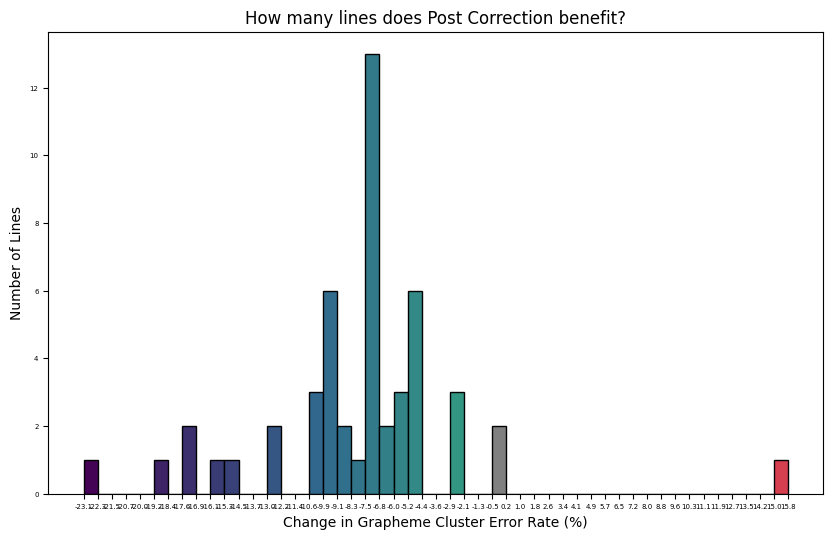

In [14]:
# Plot histogram and get bin edges and counts
plt.figure(figsize=(10, 6))
if gcer:
    counts, bin_edges, patches = plt.hist(df['difference_gcer']*100, bins=50, edgecolor='black')
else:
    counts, bin_edges, patches = plt.hist(df['difference']*100, bins=50, edgecolor='black')

# Normalize bin edges for color mapping
norm = plt.Normalize(bin_edges.min(), bin_edges.max())

# Create custom colormaps that are more color-blind friendly
colors_neg = ['#440154', '#31688e', '#35b779', '#fde725']  # Viridis-like
colors_pos = ['#fee08b', '#fc8d59', '#d53e4f']  # YlOrRd-like

cmap_neg = mcolors.LinearSegmentedColormap.from_list("custom_neg", colors_neg)
cmap_pos = mcolors.LinearSegmentedColormap.from_list("custom_pos", colors_pos)

# Apply colors to bars
for i, patch in enumerate(patches):
    # Determine bin edges
    left_edge = bin_edges[i]
    right_edge = bin_edges[i + 1]
    
    # Check if bin includes zero
    if left_edge <= 0 <= right_edge:
        # Set the color of the bin that includes zero to gray
        color = 'gray'
    elif right_edge < 0:
        # Color for bins with negative values
        bin_center = (left_edge + right_edge) / 2
        color = cmap_neg(norm(bin_center))
    else:
        # Color for bins with positive values
        bin_center = (left_edge + right_edge) / 2
        color = cmap_pos(norm(bin_center))
    
    patch.set_facecolor(color)


plt.xticks(ticks=bin_edges, fontsize=5)
plt.yticks(fontsize=5)  # Decrease the font size of x-axis ticks
# Format x-axis tick labels to one decimal place
formatter = FuncFormatter(lambda x, _: f'{x:.1f}')
plt.gca().xaxis.set_major_formatter(formatter)

plt.title('How many lines does Post Correction benefit?')
if gcer:
    plt.xlabel('Change in Grapheme Cluster Error Rate (%)')
else:
    plt.xlabel('Change in Character Error Rate (%)')
plt.ylabel('Number of Lines')

# Show the plot
plt.show()

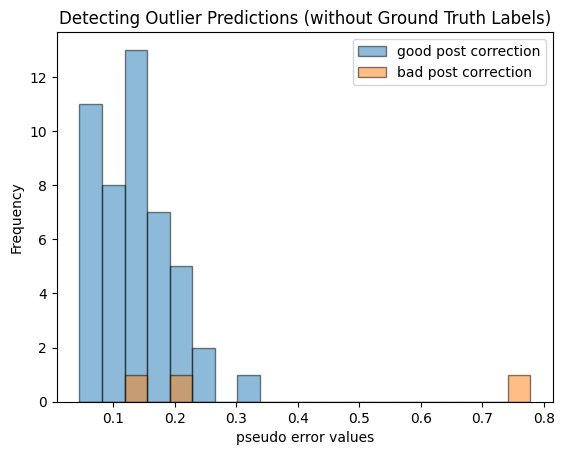

Abnormally Bad Line at : 7
Abnormally Bad Line at : 14
Abnormally Good Line at : 2
Abnormally Good Line at : 48
Abnormally Good Line at : 49
Abnormally Good Line at : 43
Abnormally Good Line at : 42
Abnormally Good Line at : 39


In [15]:
good_pseudo = []
bad_pseudo = []
bad_pseudo_indices = []
good_pseudo_indices = []

ocr_errors = []
post_correction_errors = []

nan_predicted_indices = []

for index, row in df.iterrows():

    input_text = str(row['input_text'])
    predicted_text = row['predicted_text']
    target_text = str(row['target_text'])

    ocr_error = calculate_error(target_text,input_text, gcer=gcer) #we need ground truth for this
    #try:
    post_correction_error = calculate_error(target_text,predicted_text,gcer=gcer) # we need ground truth for this too
    pseudo_error = calculate_error(predicted_text, input_text, gcer=gcer) # this is ALWAYS availabe!
    # except:

        
    

    # can we use pseudo error to guess when the (post_correction_error - ocr_error) would be positive(bad)
    if post_correction_error-ocr_error <0: #GOOD
        good_pseudo.append(pseudo_error)
        good_pseudo_indices.append(index)
    else: #BAD
        bad_pseudo.append(pseudo_error)
        bad_pseudo_indices.append(index)

    post_correction_errors.append(post_correction_error)
    ocr_errors.append(ocr_error)

num_bins = 20
# Create the histogram plot
# Determine the overall range of the data
min_val = min(np.min(good_pseudo), np.min(bad_pseudo))
max_val = max(np.max(good_pseudo), np.max(bad_pseudo))

# Create an array of bin edges
bins = np.linspace(min_val, max_val, 21)  # 21 edges to create 20 bins

# Plot the histograms
plt.hist(good_pseudo, bins=bins, alpha=0.5, label='good post correction', edgecolor='black')
plt.hist(bad_pseudo, bins=bins, alpha=0.5, label='bad post correction', edgecolor='black')



# Add labels and title
plt.xlabel('pseudo error values')
plt.ylabel('Frequency')
plt.title('Detecting Outlier Predictions (without Ground Truth Labels)')
plt.legend(loc='upper right')

# Show the plot
plt.show()


abnormal_lines_indices = []
for val,i in zip(bad_pseudo,bad_pseudo_indices):
    if val>threshold:
        print(f'Abnormally Bad Line at : {i}')
        abnormal_lines_indices.append(i)

for val,i in zip(good_pseudo,good_pseudo_indices):
    if val>threshold:
        print(f'Abnormally Good Line at : {i}')
        abnormal_lines_indices.append(i)

abnormal_lines_indices = abnormal_lines_indices+nan_predicted_indices

In machine learning it is common to split the data we have into training data, validation data and test data. The validation data helps us fine tune the hyperparameters, and the test data helps us gauge how our model will perform when deployed.\
Both, Validataion Data and Test Data are proxys for what we would observe after deployment. But unlike the Validation and Test splits, the data we observe after deployment does not have ground truth labels.\
Similarly, we have ground truth labels for our validation and test datasets. We observe that sometimes the model hallucinates really bad for some lines which brings down the CER for the entire page/manuscript. We would like to catch these lines, even in the absense of ground truth data - which would be the case when the model is deployed.\
We observe that: **If a post corrected Line A's CER compared with the ground truth is bad, then the post corrected Line A's CER when compared with the OCR output would also be bad.** We can use this observation to catch abnormal lines without the need to have ground truth labels.

In [16]:
def remove_elements(original_list, indices_to_remove):
    return [elem for i, elem in enumerate(original_list) if i not in indices_to_remove]

In [17]:
def keep_abnormal_lines_unchanged(post_correction_errors,ocr_errors,indices_to_remove):
    return_this = []
    for index, (item1, item2) in enumerate(zip(post_correction_errors, ocr_errors)):
        if index not in indices_to_remove:
            return_this.append(item1)
        else:
            return_this.append(item2)
    return return_this


In [18]:
if gcer:
    print(f'The average GCER of the OCRed Text is {np.mean(ocr_errors)}.\nThe average GCER of the Post-Corrected Text is {np.mean(post_correction_errors)}.\nAfter Removing Abnormal Lines the GCER becomes {np.mean(keep_abnormal_lines_unchanged(post_correction_errors,ocr_errors,abnormal_lines_indices))}')
else:
    print(f'The average CER of the OCRed Text is {np.mean(ocr_errors)}.\nThe average CER of the Post-Corrected Text is {np.mean(post_correction_errors)}.\nAfter Removing Abnormal Lines the CER becomes {np.mean(keep_abnormal_lines_unchanged(post_correction_errors,ocr_errors,abnormal_lines_indices))}')

print('')
print("40 Page trained pure CNN-LSTM")
if not gcer:
    print(np.mean(df['pure_cnnlstm_cer']))
else:
    print(np.mean(df['pure_cnnlstm_gcer']))

#print(f'The average CER of the OCRed Text is {np.mean(ocr_errors)}.\nThe average CER of the Post-Corrected Text is {np.mean(post_correction_errors)}.\nAfter Removing Abnormal Lines the CER becomes')

The average GCER of the OCRed Text is 0.22289839033703251.
The average GCER of the Post-Corrected Text is 0.14559751310217556.
After Removing Abnormal Lines the GCER becomes 0.15202531898496835

40 Page trained pure CNN-LSTM
0.10684630250469114


In [19]:
#for experiment 5: 1,3

# Abnormal Line at : 179
# Abnormal Line at : 359
# Abnormal Line at : 491
# Abnormal Line at : 515

Blue     : Extra
Red   : Missing
Yellow  : Replaced
No color: Unchanged


7 Page trained OCR Output GCER:27.500000000000004 CER:15.0
Ground Truth  : nānvayostviticet .omitibrūmoyadikiṃcittasyābhāvyaṃpradarśaye  ḥyāgaeveticenna  .tasyaikasyāṃkaraṇatve  
Prediction    : nonvayostviticetaṃ mitidrūmoyādikiṃcittasyābhāvyaṃprada śay aiḥyāgaevetic   aiś.tasyaikasyāṃkaraṇatv ai

40 Page trained OCR Output GCER:12.5 CER:6.382978723404253
Ground Truth  : nānvayostviticet.omitibrūmoyadikiṃcittasyābhāvyaṃpradarśaye  ḥyāgaeveticenna.tasyaikasyāṃkaraṇatve
Prediction    : nonvayost_iticet.amitibrūmoyadikiṃcittasyābhāvyaṃpradarśay aiḥyāgaeveticenma.tasyaikasyāṃkaraṇatve

Hybrid OCR Output GCER:17.5 CER:11.0
Ground Truth  : nānvayostviticet.omitibrūmoyadikiṃcittasyābhāvyaṃpradarśaye  ḥyāgaeveticenn    a.tasyaikasyāṃkaraṇatve  
Prediction    : nonvayostviticet. mitibrūmoyādikiṃcittasyābhāvyaṃpradarśay aiḥyāgaevetic   aitra.tasyaikasyāṃkaraṇatv ai

Original Line Image:


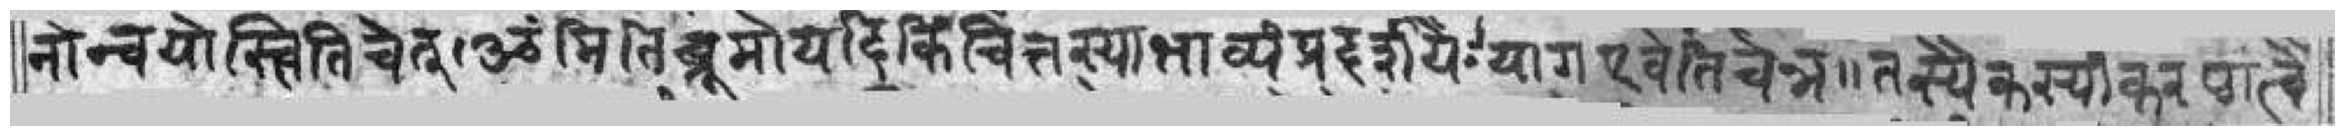

In [23]:
analyse_line(df,27)
#mark missing character as red too..




In [21]:
transliterate._ocred_text[0]

'ससबंधस्यप्राथमिकबोधेएवविषयत्वापत्तेश्च।किचसप्तदशसख्यायायागेन्वयेनतद्वहुत्वेसिद्धेतद'

In [49]:
error_counts_train_paths = [
    fold_1_path + 'error_counts_train.json',
    # fold_2_path + 'error_counts_train.json',
    # fold_3_path + 'error_counts_train.json'
]
error_counts_test_paths = [
    fold_1_path + 'error_counts_test.json',
    # fold_2_path + 'error_counts_test.json',
    # fold_3_path + 'error_counts_test.json'
]


In [50]:
# Initialize an empty dictionary to store the combined data
data_train = {}

# Load and combine the JSON files
for path in error_counts_train_paths:
    with open(path, 'r', encoding='utf-8') as file:
        data = json.load(file)
        # Merge the loaded data into the combined_data dictionary
        data_train.update(data)

data_test = {}

# Load and combine the JSON files
for path in error_counts_test_paths:
    with open(path, 'r', encoding='utf-8') as file:
        data = json.load(file)
        # Merge the loaded data into the combined_data dictionary
        data_test.update(data)

In [51]:

display_side_by_side(data_train, data_test, title1="Changes made when transforming the OCR OUTPUT to GROUND TRUTH", title2="Changes made when transforming the OCR OUTPUT using POST CORRECTION")
